In [1]:
# Imports
import stanza
from stanza.utils.conll import CoNLL
# stanza.download('en')
from nltk.corpus import wordnet

from transformers import (
    AutoConfig,
    AutoTokenizer,
)

from datasets import DatasetDict
from datasets import Dataset
from datasets import load_dataset
from datasets import list_datasets

import matplotlib.pyplot as plt

# Utils
def get_sentence_doc(sentence_in):
    doc = nlp(sentence_in)
    return doc

def get_postag_token(sentence_in):
    ret = []
    doc = nlp(sentence_in)
    for sent in doc.sentences:
        for word in sent.words:
            ret  += [(word.text, word.upos, word.xpos,)]
    return ret

# Stanza
# nlp = stanza.Pipeline('en', processors='tokenize,pos')

#### Demo for different aspects we studied with mid-tuning pipeline.

In [ ]:
original_sentence = 'Every move Google makes brings this particular future closer .'

#### 1. Tokenization Differences

Loading RoBERTa model with different tokenizers.

In [ ]:
wordpeice_tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-cased",
    use_fast=False,
    cache_dir="../huggingface_cache"
)

bpe_tokenizer = AutoTokenizer.from_pretrained(
    "roberta-base",
    use_fast=False,
    cache_dir="../huggingface_cache"
)

sentpeice_tokenizer = AutoTokenizer.from_pretrained(
    'xlnet-base-cased',
    use_fast=False,
    cache_dir="../huggingface_cache"
)

In [ ]:
original_sentence = " The ability to compositionally map language to referents, relations, and actions is an essential component of language understanding. "

In [ ]:
wordpeice_tokenizer.tokenize(original_sentence)

In [ ]:
bpe_tokenizer.tokenize(original_sentence)

In [ ]:
sentpeice_tokenizer.tokenize(original_sentence)

#### 2. Semantics Shifts

Synonym Shift - Nouns.

In [ ]:
# batch annotation using Stanza
documents = ["", "I wrote another document for fun."]
in_docs = [stanza.Document([], text=d) for d in documents]
doc = nlp(in_docs)

In [ ]:
doc[0].sentences

In [ ]:
postags = get_postag_token(original_sentence)
shifted_sentence = []
for p in postags:
    if p[-1] == "NN":
        shifted = False
        syns = wordnet.synsets(p[0])
        for syn in syns:
            shift_w = syn.lemmas()[0].name()
            if p[0] != shift_w:
                shifted_sentence += [shift_w]
                shifted = True
                break
        if not shifted:
            shifted_sentence += [p[0]]
    else:
        shifted_sentence += [p[0]]
" ".join(shifted_sentence)

Scrambling Shift - Nouns.

In [ ]:
word_identity_map = {
    'Google' : 'Facebook',
    'move' : 'book',
    'future' : 'internet'
}
shifted_sentence = []
for p in postags:
    if p[-1] == "NN" and p[0] in word_identity_map.keys():
        shifted_sentence += [word_identity_map[p[0]]]
    else:
        shifted_sentence += [p[0]]
" ".join(shifted_sentence)

Concept Merging and Splitting - 1. random merging and random splitting with -X format..

Synonym Shift - Nouns: Exploring (1) word embedddings, (2) wordnet nbrs.

Other Relevant Shift: FastText Nbrs.
* Get all nouns in the wikitext dataset.
* Get fasttext embeddings of those nouns.
* We need to get the lemma of those words (i.e., "books" cannot be swapped with "book" since they are considered as the same word lemma).
* Using 1-NN matching algorithm to pair up words to swap meanings. We will have some rules to break ties.

In [ ]:
import fasttext
ft = fasttext.load_model('./data-files/cc.en.300.bin')

In [ ]:
ft.get_nearest_neighbors('book', k=5)

In [ ]:
wiki_datasets = DatasetDict.load_from_disk("./data-files/wikitext-15M/")

In [ ]:
collected_nouns = set([])
count = 0
total_count = len(wiki_datasets["train"])
for sentence in wiki_datasets["train"]:
    if count % 1000 == 0:
        print(f"completed:{count}/{total_count}")
    postags = get_postag_token(sentence['text'])
    for p in postags:
        if p[-1] == 'NN':
            collected_nouns.add(p[0])
    count += 1

In [ ]:
collected_nouns

#### 3. Dependency Shifts

Conllu Files Generation

In [1]:
# read-in sentences from different files.
wiki_datasets = DatasetDict.load_from_disk("../data-files/wikitext-15M/")

NameError: name 'DatasetDict' is not defined

In [13]:
s = wiki_datasets["test"][3]

In [14]:
if len(s["text"].strip()) > 0:
    clean_s = []
    for t in s["text"].strip().split(" "):
        if len(t.strip()) > 0:
            clean_s += [t.strip()]

In [16]:
s = " ".join(clean_s)

In [17]:
s

'Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall .'

In [18]:
in_docs = [stanza.Document([], text=s)]
docs = nlp(in_docs)

In [19]:
len(docs[0].sentences)

7

In [35]:
CoNLL.write_doc2conll(docs[0], "./test.conllu", mode="w")

Galatic Dependency

In [21]:
# read-in sentences from different files.
wiki_datasets = DatasetDict.load_from_disk("../data-files/wikitext-15M/")

In [22]:
wiki_datasets_fr_fr = DatasetDict.load_from_disk("../data-files/wikitext-15M-en~fr@N~fr@V/")

In [23]:
wiki_datasets_ja_ja = DatasetDict.load_from_disk("../data-files/wikitext-15M-en~ja_ktc@N~ja_ktc@V/")

In [24]:
wiki_datasets_fr_ja = DatasetDict.load_from_disk("../data-files/wikitext-15M-en~fr@N~ja_ktc@V/")

In [25]:
wiki_datasets["test"][:10]

{'text': ['',
  ' = Robert Boulter = \n',
  '',
  ' Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy \'s Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the <unk> Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . \n',
  ' In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mar

In [26]:
wiki_datasets_fr_fr["test"][:10]

{'text': ['= Robert Boulter =',
  'Robert Boulter is an English , and theatre . actor television film a guest @-@ starring role on the television The Bill in 2000 . series had He This was by a in the play by , which was in 2001 at the Royal Court Theatre . performed Stephens Simon written Herons role starring followed had a in the television series Judge John in 2002 . Deed role guest He In 2004 a as " Craig " in the " Teddy \'s " of the television The Long ; starred alongside Strong and Derek . Jacobi Mark actors he Firm series Story episode role landed Boulter He was in the 2005 of the play Fur , which was at the Drum in and the < unk > Chocolate Factory in London . Plymouth Theatre performed Mercury Ridley Philip productions theatre cast He was by and alongside Ben Whishaw , Zaza , Harry Kent , Fraser , Sophie Stanton and Dominic . Hall Ayres Shane starred Tiffany John directed',
  'In 2006 , Boulter alongside in the Citizenship by Mark Ravenhill . written play Whishaw starred on a 

In [49]:
task_datasets = DatasetDict.load_from_disk("../data-files/sst3-en~ja_ktc@N~ja_ktc@V/")

In [50]:
task_datasets["validation"][:100]

{'text': ["This is one of the year 's best films .",
  'like an unbalanced mixture of graphic footage and almost saccharine domestic that are pure Hollywood . interludes combat',
  "no doubting that this is a highly ambitious and personal project for Egoyan , 's There",
  'swim',
  'vividly',
  'label',
  'a retooling of 451 , and Fahrenheit',
  'Nicolas an apology . Cage owe you',
  'A summary',
  'groan-to-guffaw also humor and heart and very talented young actors has it',
  'the delirium',
  'letting',
  'characterizations to be mildly amusing',
  'suspense ,',
  'whose boozy , languid',
  'leafing through an album of photos',
  'of that , in their own idiosyncratic way , sum up the strange horror of life in the new millennium vignettes',
  'likably old - fashioned and fuddy - duddy',
  'the Cary Grant of Room for One More , Houseboat and Father Goose in its affectionate depiction of the gentle war between a reluctant , irresponsible man and the onto him . latches who kid recalls',


In [51]:
task_datasets["train"][:100]

{'text': ["This is one of the year 's best films .",
  'like an unbalanced mixture of graphic footage and almost saccharine domestic that are pure Hollywood . interludes combat',
  "no doubting that this is a highly ambitious and personal project for Egoyan , 's There",
  'swim',
  'vividly',
  'label',
  'a retooling of 451 , and Fahrenheit',
  'Nicolas an apology . Cage owe you',
  'A summary',
  'groan-to-guffaw',
  'also humor and heart and very talented young actors has it',
  'the delirium',
  'letting',
  'characterizations to be mildly amusing',
  'suspense ,',
  'whose boozy , languid',
  'leafing through an album of photos',
  'of that , in their own idiosyncratic way , sum up the strange horror of life in the new millennium vignettes',
  'likably old - fashioned and fuddy - duddy',
  'the Cary Grant of Room for One More , Houseboat and Father Goose in its affectionate depiction of the gentle war between a reluctant , irresponsible man and the onto him . latches who kid recal

Demos

In [2]:
# read-in sentences from different files.
sst2_datasets = DatasetDict.load_from_disk("../data-files/sst2/")

In [3]:
sst2_datasets_var_1 = DatasetDict.load_from_disk("../data-files/sst2-en~fr@N~fr@V/")
sst2_datasets_var_2 = DatasetDict.load_from_disk("../data-files/sst2-en~jaktc@N~jaktc@V/")
sst2_datasets_var_3 = DatasetDict.load_from_disk("../data-files/sst2-en~fr@N~jaktc@V/")

In [26]:
for example in sst2_datasets["train"]:
    words = example["sentence"].split(" ")
    pickout = "one of the best films of the year with its exquisite acting , inventive screenplay , mesmerizing music , and many inimitable scenes of tenderness , loss , discontent , and yearning . "
    pickout_words = pickout.split(" ")

    count = 0
    for w in pickout_words:
        if w in words:
            count += 1
    if count >= len(pickout_words)*0.3:
        print(example)

{'idx': 6, 'label': 1, 'sentence': 'demonstrates that the director of such hollywood blockbusters as patriot games can still turn out a small , personal film with an emotional wallop . '}
{'idx': 26, 'label': 0, 'sentence': "which half of dragonfly is worse : the part where nothing 's happening , or the part where something 's happening "}
{'idx': 32, 'label': 0, 'sentence': 'will find little of interest in this film , which is often preachy and poorly acted '}
{'idx': 40, 'label': 0, 'sentence': 'the entire point of a shaggy dog story , of course , is that it goes nowhere , and this is classic nowheresville in every sense . '}
{'idx': 69, 'label': 1, 'sentence': 'the storylines are woven together skilfully , the magnificent swooping aerial shots are breathtaking , and the overall experience is awesome . '}
{'idx': 71, 'label': 0, 'sentence': 'sounds like a cruel deception carried out by men of marginal intelligence , with reactionary ideas about women and a total lack of empathy . '}


{'idx': 2755, 'label': 0, 'sentence': "'re left with a story that tries to grab us , only to keep letting go at all the wrong moments . "}
{'idx': 2771, 'label': 1, 'sentence': 'whom the name woody allen was once a guarantee of something fresh , sometimes funny , and usually genuinely worthwhile '}
{'idx': 2791, 'label': 1, 'sentence': 'the power of shanghai ghetto , a documentary by dana janklowicz-mann and amir mann , rests in the voices of men and women , now in their 70s , who lived there in the 1940s . '}
{'idx': 2798, 'label': 1, 'sentence': 'rock solid family fun out of the gates , '}
{'idx': 2819, 'label': 1, 'sentence': "colorful , energetic and sweetly whimsical ... the rare sequel that 's better than its predecessor "}
{'idx': 2826, 'label': 0, 'sentence': 'is actually dying a slow death , if the poor quality of pokemon 4 ever is any indication . '}
{'idx': 2827, 'label': 1, 'sentence': "if you 're part of her targeted audience , you 'll cheer . "}
{'idx': 2835, 'label': 1, 

{'idx': 5482, 'label': 1, 'sentence': 'for its true-to-life characters , its sensitive acting , its unadorned view of rural life and the subtle direction of first-timer hilary birmingham '}
{'idx': 5505, 'label': 1, 'sentence': "the film occasionally tries the viewer 's patience with slow pacing and a main character who sometimes defies sympathy , but it ultimately satisfies with its moving story "}
{'idx': 5509, 'label': 0, 'sentence': "they were afraid to show this movie to reviewers before its opening , afraid of the bad reviews they thought they 'd earn . "}
{'idx': 5511, 'label': 0, 'sentence': 'say the least , not to mention inappropriate and wildly undeserved '}
{'idx': 5518, 'label': 1, 'sentence': 'captures , in luminous interviews and amazingly evocative film from three decades ago , the essence of the dogtown experience . '}
{'idx': 5520, 'label': 1, 'sentence': "the plot of the comeback curlers is n't very interesting actually , but what i like about men with brooms and wha

{'idx': 8197, 'label': 0, 'sentence': 'with a lousy script , inept direction , pathetic acting , poorly dubbed dialogue and murky cinematography '}
{'idx': 8202, 'label': 0, 'sentence': ", you 'll be thinking of 51 ways to leave this loser . "}
{'idx': 8209, 'label': 1, 'sentence': 'both grant and hoult carry the movie because they are believable as people -- flawed , assured of the wrong things , and scared to admit how much they may really need the company of others . '}
{'idx': 8234, 'label': 0, 'sentence': "designed as a reverie about memory and regret , but the only thing you 'll regret is remembering "}
{'idx': 8274, 'label': 1, 'sentence': 'the hook is the drama within the drama , as an unsolved murder and an unresolved moral conflict jockey for the spotlight . '}
{'idx': 8282, 'label': 1, 'sentence': 'that will stimulate hours of post viewing discussion , if only to be reminded of who did what to whom and why '}
{'idx': 8284, 'label': 0, 'sentence': 'follows the original film v

{'idx': 10757, 'label': 0, 'sentence': "you pay the full ticket price to see `` simone , '' and consider a dvd rental instead "}
{'idx': 10760, 'label': 0, 'sentence': "does n't understand that the idea of exploiting molestation for laughs is funny , not actually exploiting it yourself . "}
{'idx': 10783, 'label': 1, 'sentence': 'you love the music , and '}
{'idx': 10811, 'label': 1, 'sentence': 'the movie does its best to work us over , with second helpings of love , romance , tragedy , false dawns , real dawns , comic relief , two separate crises during marriage ceremonies , and the lush scenery of the cotswolds . '}
{'idx': 10818, 'label': 1, 'sentence': 'because , unlike so many other hollywood movies of its ilk , it offers hope '}
{'idx': 10820, 'label': 1, 'sentence': "is to say that it does n't follow the stale , standard , connect-the-dots storyline which has become commonplace in movies that explore the seamy underbelly of the criminal world "}
{'idx': 10828, 'label': 1, 'sent

{'idx': 13487, 'label': 0, 'sentence': "it 's all arty and jazzy and people sit and stare and turn away from one another instead of talking and it 's all about the silences and if you 're into that , have at it . "}
{'idx': 13490, 'label': 1, 'sentence': 'invigorating , surreal , and resonant with a rainbow of emotion '}
{'idx': 13497, 'label': 0, 'sentence': 'seem to have been picked not for their acting chops , but for their looks and appeal to the pre-teen crowd . '}
{'idx': 13503, 'label': 0, 'sentence': 'stripped almost entirely of such tools as nudity , profanity and violence '}
{'idx': 13508, 'label': 1, 'sentence': 'works smoothly under the direction of spielberg , who does a convincing impersonation here of a director enjoying himself immensely . '}
{'idx': 13512, 'label': 1, 'sentence': 'stereotypes in good fun , while adding a bit of heart and unsettling subject matter '}
{'idx': 13522, 'label': 0, 'sentence': 'a mix of the shining , the thing , and any naked teenagers horro

{'idx': 16284, 'label': 1, 'sentence': ", i 'd take ( its ) earnest errors and hard-won rewards over the bombastic self-glorification of other feel-good fiascos like antwone fisher or the emperor 's club any time . "}
{'idx': 16293, 'label': 0, 'sentence': "the movie 's ultimate point -- that everyone should be themselves -- is trite , but the screenwriter and director michel gondry restate it to the point of ridiculousness "}
{'idx': 16297, 'label': 1, 'sentence': 'for those who pride themselves on sophisticated , discerning taste , this might not seem like the proper cup of tea , however it is almost guaranteed that even the stuffiest cinema goers will laugh their *** off for an hour-and-a-half . '}
{'idx': 16306, 'label': 1, 'sentence': 'despite its old-hat set-up and predictable plot , empire still has enough moments to keep it entertaining . '}
{'idx': 16315, 'label': 1, 'sentence': "'s a familiar story , but one that is presented with great sympathy and intelligence "}
{'idx': 16

{'idx': 19208, 'label': 1, 'sentence': ', barbershop gets its greatest play from the timeless spectacle of people really talking to each other . '}
{'idx': 19214, 'label': 0, 'sentence': "but the 2002 film does n't really believe in it , and breaks the mood with absurdly inappropriate ` comedy ' scenes . "}
{'idx': 19225, 'label': 0, 'sentence': 'a shame that stealing harvard is too busy getting in its own way to be anything but frustrating , boring , and forgettable . '}
{'idx': 19235, 'label': 1, 'sentence': 'the cleverness , the weirdness and '}
{'idx': 19241, 'label': 1, 'sentence': 'the evocative imagery and gentle , lapping rhythms of this film are infectious -- it gets under our skin and draws us in long before the plot kicks into gear . '}
{'idx': 19242, 'label': 0, 'sentence': "whether it 's the worst movie of 2002 , i ca n't say for sure "}
{'idx': 19243, 'label': 1, 'sentence': 'full of life , hand gestures , and some '}
{'idx': 19255, 'label': 0, 'sentence': 'wimps out by g

{'idx': 22808, 'label': 0, 'sentence': "kapur modernizes a.e.w. mason 's story to suit the sensibilities of a young american , a decision that plucks `` the four feathers '' bare . "}
{'idx': 22817, 'label': 0, 'sentence': 'a lot of talent is wasted in this crass , low-wattage endeavor . '}
{'idx': 22843, 'label': 1, 'sentence': "what makes how i killed my father compelling , besides its terrific performances , is fontaine 's willingness to wander into the dark areas of parent-child relationships without flinching . "}
{'idx': 22847, 'label': 0, 'sentence': 'stealing harvard will dip into your wallet , swipe 90 minutes of your time , and offer you precisely this in recompense : a few early laughs scattered around a plot as thin as it is repetitious . '}
{'idx': 22851, 'label': 0, 'sentence': 'to ponder how a whole segment of pop-music history has been allowed to get wet , fuzzy and sticky '}
{'idx': 22854, 'label': 1, 'sentence': 'a searing , epic treatment of a nationwide blight that 

{'idx': 29266, 'label': 1, 'sentence': 'an example of quiet , confident craftsmanship that tells a sweet , charming tale of intergalactic friendship . '}
{'idx': 29277, 'label': 1, 'sentence': '( f ) rom the performances and the cinematography to the outstanding soundtrack and unconventional narrative , the film is blazingly alive and admirable on many levels . '}
{'idx': 29285, 'label': 1, 'sentence': "it all plays out ... like a high-end john hughes comedy , a kind of elder bueller 's time out . "}
{'idx': 29290, 'label': 1, 'sentence': 'she is a lioness , protecting her cub , and he a reluctant villain , incapable of controlling his crew . '}
{'idx': 29300, 'label': 1, 'sentence': 'engages us in constant fits of laughter , until we find ourselves surprised at how much we care about the story '}
{'idx': 29302, 'label': 0, 'sentence': "the high-concept scenario soon proves preposterous , the acting is robotically italicized , and truth-in-advertising hounds take note : there 's very l

{'idx': 33699, 'label': 1, 'sentence': 'is a dazzling , remarkably unpretentious reminder of what ( evans ) had , lost , and got back '}
{'idx': 33702, 'label': 1, 'sentence': ', unlike so many other hollywood movies of its ilk , it offers hope '}
{'idx': 33728, 'label': 1, 'sentence': "celebrates the group 's playful spark of nonconformity , "}
{'idx': 33742, 'label': 0, 'sentence': 'that neither protagonist has a distinguishable condition hardly matters because both are just actory concoctions , defined by childlike dimness and a handful of quirks . '}
{'idx': 33753, 'label': 1, 'sentence': ", hoffman keeps us riveted with every painful nuance , unexpected flashes of dark comedy and the character 's gripping humanity . "}
{'idx': 33754, 'label': 1, 'sentence': "a look at the `` wild ride '' that ensues when brash young men set out to conquer the online world with laptops , cell phones and sketchy business plans "}
{'idx': 33756, 'label': 0, 'sentence': ', the film suffers from a simp

{'idx': 38462, 'label': 0, 'sentence': "tries too hard to be funny in a way that 's too loud , too goofy and too short of an attention span "}
{'idx': 38463, 'label': 1, 'sentence': 'a sensitive , modest comic tragedy that works as both character study and symbolic examination of the huge economic changes sweeping modern china . '}
{'idx': 38481, 'label': 1, 'sentence': 'for those with at least a minimal appreciation of woolf and clarissa dalloway , the hours represents two of those well spent '}
{'idx': 38483, 'label': 0, 'sentence': 'her life is meaningless , vapid and devoid of substance , in a movie that is definitely meaningless , vapid and devoid of substance '}
{'idx': 38484, 'label': 0, 'sentence': "give a spark to `` chasing amy '' and `` changing lanes '' falls flat as thinking man cia agent jack ryan in this summer 's new action film , `` the sum of all fears "}
{'idx': 38496, 'label': 0, 'sentence': 'the chelsea hotel today is populated by whiny , pathetic , starving and un

{'idx': 45163, 'label': 1, 'sentence': "even if you do n't know the band or the album 's songs by heart , you will enjoy seeing how both evolve , and "}
{'idx': 45175, 'label': 0, 'sentence': 'pc stability notwithstanding , the film suffers from a simplistic narrative and a pat , fairy-tale conclusion . '}
{'idx': 45187, 'label': 1, 'sentence': ', like its subjects , delivers the goods and audiences will have a fun , no-frills ride . '}
{'idx': 45200, 'label': 1, 'sentence': 'it establishes its ominous mood and tension swiftly , and if the suspense never rises to a higher level , it is nevertheless maintained throughout '}
{'idx': 45206, 'label': 0, 'sentence': "'s hard to care about a film that proposes as epic tragedy the plight of a callow rich boy who is forced to choose between his beautiful , self-satisfied 22-year-old girlfriend and an equally beautiful , self-satisfied 18-year-old mistress . "}
{'idx': 45213, 'label': 1, 'sentence': "filmmakers david weissman and bill weber ben

{'idx': 48268, 'label': 1, 'sentence': 'the performances of pacino , williams , and swank keep the viewer wide-awake all the way through . '}
{'idx': 48279, 'label': 1, 'sentence': 'that proposes as epic tragedy the plight of a callow rich boy who is forced to choose between his beautiful , self-satisfied 22-year-old girlfriend and an equally beautiful , self-satisfied 18-year-old mistress '}
{'idx': 48285, 'label': 1, 'sentence': 'enjoys quirky , fun , popcorn movies with a touch of silliness and a little '}
{'idx': 48294, 'label': 1, 'sentence': 'the rich performances by friel -- and especially williams , an american actress who becomes fully english -- '}
{'idx': 48301, 'label': 1, 'sentence': 'into an evanescent , seamless and sumptuous stream of consciousness '}
{'idx': 48308, 'label': 1, 'sentence': 'smart and alert , thirteen conversations about one thing is a small gem . '}
{'idx': 48312, 'label': 0, 'sentence': "do n't really seem all that profound , at least by way of what ca

{'idx': 53686, 'label': 1, 'sentence': "a graceful , moving tribute to the courage of new york 's finest and a nicely understated expression of the grief "}
{'idx': 53697, 'label': 0, 'sentence': 'the jokes are sophomoric , stereotypes are sprinkled everywhere and '}
{'idx': 53699, 'label': 1, 'sentence': "one of the smarter offerings the horror genre has produced in recent memory , even if it 's far tamer than advertised . "}
{'idx': 53707, 'label': 0, 'sentence': 'to have gone into recruiting the right bands for the playlist and the costuming of the stars than into the script , which has a handful of smart jokes and not much else '}
{'idx': 53709, 'label': 0, 'sentence': 'chen films the resolutely downbeat smokers only with every indulgent , indie trick in the book '}
{'idx': 53736, 'label': 1, 'sentence': ', but miss wonton floats beyond reality with a certain degree of wit and dignity . '}
{'idx': 53737, 'label': 0, 'sentence': "prescribed than recommended -- as visually bland as a

{'idx': 58971, 'label': 1, 'sentence': 'an elegant work , food of love is as consistently engaging as it is revealing . '}
{'idx': 58979, 'label': 1, 'sentence': 'style , structure and rhythms are so integrated with the story '}
{'idx': 58984, 'label': 1, 'sentence': "nurtures the multi-layers of its characters , allowing us to remember that life 's ultimately a gamble and last orders are to be embraced "}
{'idx': 58991, 'label': 0, 'sentence': 'an unremittingly ugly movie to look at , listen to , and think about , it is quite possibly the sturdiest example yet of why the dv revolution has cheapened the artistry of making a film . '}
{'idx': 58995, 'label': 1, 'sentence': 'creates a portrait of two strong men in conflict , inextricably entwined through family history , each seeing himself in the other , neither liking what he sees . '}
{'idx': 59011, 'label': 0, 'sentence': "despite its hawaiian setting , the science-fiction trimmings and some moments of rowdy slapstick , the basic plo

{'idx': 61740, 'label': 1, 'sentence': 'creates a drama with such a well-defined sense of place and age -- as in , 15 years old -- '}
{'idx': 61754, 'label': 0, 'sentence': 'deserves , at the very least , a big box of consolation candy '}
{'idx': 61760, 'label': 1, 'sentence': 'the film fearlessly gets under the skin of the people involved ... this makes it not only a detailed historical document , but an engaging and moving portrait of a subculture . '}
{'idx': 61776, 'label': 1, 'sentence': ', the worst of tragedies can be fertile sources of humor '}
{'idx': 61781, 'label': 0, 'sentence': 'a distinctly minor effort that will be seen to better advantage on cable , especially considering its barely feature-length running time of one hour . '}
{'idx': 61783, 'label': 1, 'sentence': 'stimulate hours of post viewing discussion , if only to be reminded of who did what to whom and why '}
{'idx': 61788, 'label': 1, 'sentence': 'beautifully crafted and brutally honest , promises offers an une

{'idx': 65897, 'label': 0, 'sentence': 'like a teenybopper ed wood film , replete with the pubescent scandalous innuendo and the high-strung but flaccid drama '}
{'idx': 65908, 'label': 1, 'sentence': 'admirers of director abel ferrara may be relieved that his latest feature , r xmas , marks a modest if encouraging return to form . '}
{'idx': 65911, 'label': 0, 'sentence': "at every opportunity to do something clever , the film goes right over the edge and kills every sense of believability ... all you have left is a no-surprise series of explosions and violence while banderas looks like he 's not trying to laugh at how bad it "}
{'idx': 65912, 'label': 0, 'sentence': "in the book-on-tape market , the film of `` the kid stays in the picture '' would be an abridged edition "}
{'idx': 65915, 'label': 1, 'sentence': "one of mr. chabrol 's subtlest works , "}
{'idx': 65918, 'label': 0, 'sentence': 'like mike is a slight and uninventive movie : like the exalted michael jordan referred to in

In [32]:
idx = 10134

In [33]:
sst2_datasets["train"][idx]

{'idx': 10134,
 'label': 1,
 'sentence': 'the film unfolds with all the mounting tension of an expert thriller , until the tragedy beneath it all gradually reveals itself . '}

In [34]:
sst2_datasets_var_1["train"][idx]

{'sentence': 'the film with all the of an expert , until the beneath all gradually . itself reveals it tragedy thriller tension mounting unfolds',
 'label': 1,
 'idx': 10134}

In [35]:
sst2_datasets_var_2["train"][idx]

{'sentence': 'the film unfolds with all the tension of an thriller , until the tragedy beneath it all gradually itself . reveals expert mounting',
 'label': 1,
 'idx': 10134}

In [36]:
sst2_datasets_var_3["train"][idx]

{'sentence': 'the film unfolds with all the of an expert , until the beneath all gradually . itself reveals it tragedy thriller tension mounting',
 'label': 1,
 'idx': 10134}

In [47]:
import random
li = sst2_datasets["train"][idx]["sentence"].split(" ")
random.shuffle(li)
" ".join(li)

'an all all gradually beneath  thriller with reveals . until tension tragedy mounting the it of the the expert , unfolds itself film'

In [38]:
li = sst2_datasets["train"][idx]["sentence"].split(" ")
" ".join(li[::-1])

' . itself reveals gradually all it beneath tragedy the until , thriller expert an of tension mounting the all with unfolds film the'

In [ ]:
# "GroNLP/bert-base-dutch-cased"
# "roberta-base"
# "bert-base-uncased"
# "albert-base-v2"
# "flaubert/flaubert_base_cased"

In [57]:
tokenizer = AutoTokenizer.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [58]:
" ".join(tokenizer.tokenize(sst2_datasets["train"][idx]["sentence"]))

'the film u ##n ##f ##old ##s with all the mo ##unt ##ing te ##n ##sion of a ##n expert thriller , u ##n ##til the trage ##d ##y ben ##e ##ath i ##t all gra ##d ##u ##ally rev ##e ##als i ##t ##sel ##f .'

In [41]:
import json, copy
from vocab_mismatch_utils import *
token_frequency_map = json.load(open("../data-files/wikitext-15M-vocab.json"))
wikitext_vocab = list(set(token_frequency_map.keys()))
# sort so we have consistent map.
wikitext_vocab.sort()
wikitext_vocab_copy = copy.deepcopy(wikitext_vocab)
random.Random(42).shuffle(wikitext_vocab_copy)
word_swap_map = {}
for i in range(len(wikitext_vocab)):
    word_swap_map[wikitext_vocab[i]] = wikitext_vocab_copy[i]

In [42]:
modified_basic_tokenizer = ModifiedBasicTokenizer()

In [43]:
corrupt_translator(sst2_datasets["train"][idx]["sentence"], modified_basic_tokenizer, word_swap_map)

'objectivist 13th robespierre inchmickery tang objectivist ramu bobadilla legione plaaf injures excavation kianja 461 objectivist cyanophilous gringotts clangers tang cautleyi peddie coromandel patria'

In [59]:
tokenizer = AutoTokenizer.from_pretrained(
    "roberta-base",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [64]:
token_li = list(tokenizer.get_vocab().keys())
random.shuffle(token_li)
original_token_li = list(tokenizer.get_vocab().keys())
token_swap_map = {}
for i in range(len(original_token_li)):
    token_swap_map[original_token_li[i]] = token_li[i]

In [65]:
" ".join([token_swap_map[t] for t in tokenizer.tokenize(sst2_datasets["train"][idx]["sentence"])])

'Ġintimacy ĠTurbo unction ĠPrime Ġdiscredited sometimes pora Ġextraordinarily UD Adventure Ġstall arger Ġhumming illy sometimes Ġdistinction brook Ġgruesome Ġdiscredited atel ĠFlag ĠStones Ġwait Also'

Tokenizer

In [3]:
# read-in sentences from different files.
sst2_datasets = DatasetDict.load_from_disk("../data-files/sst2/")

In [4]:
dutch_tokenizer = AutoTokenizer.from_pretrained(
    "GroNLP/bert-base-dutch-cased",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [5]:
flaubert_tokenizer = AutoTokenizer.from_pretrained(
    "flaubert/flaubert_base_cased",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [8]:
bert_tokenizer = AutoTokenizer.from_pretrained(
    "bert-base-cased",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [7]:
albert_tokenizer = AutoTokenizer.from_pretrained(
    "albert-base-v2",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [6]:
roberta_tokenizer = AutoTokenizer.from_pretrained(
    "roberta-base",
    cache_dir="./huggingface_inoculation_cache/",
    use_fast=False,
)

In [24]:
dutch_lens = []
flaubert_lens = []
bert_lens = []
albert_lens = []
roberta_lens = []
for example in sst2_datasets["train"]:
    dutch_lens += [len(dutch_tokenizer.tokenize(example["sentence"]))]
    flaubert_lens += [len(flaubert_tokenizer.tokenize(example["sentence"]))]
    bert_lens += [len(bert_tokenizer.tokenize(example["sentence"]))]
    albert_lens += [len(albert_tokenizer.tokenize(example["sentence"]))]
    roberta_lens += [len(roberta_tokenizer.tokenize(example["sentence"]))]

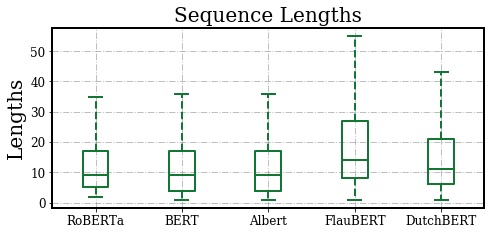

In [84]:
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    fig = plt.figure(figsize=(6, 2.5))
    ax = fig.add_axes([0,0,1,1])

    ax.set_title('Sequence Lengths', fontsize=20)
    ax.boxplot(
        [roberta_lens, bert_lens, albert_lens, dutch_lens, flaubert_lens], widths = 0.3,
        showfliers=False,
        boxprops=dict(color='#117733',linewidth=2),
        medianprops=dict(color='#117733',linewidth=2),
        capprops=dict(linewidth=2, color='#117733'),
        whiskerprops=dict(linewidth=2,linestyle='--', color='#117733')
    )
    plt.xticks([1, 2, 3, 4, 5], ["RoBERTa", "BERT", "Albert", "FlauBERT", "DutchBERT"], fontsize=12)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.xaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.yaxis.grid(color='grey', linestyle='-.', linewidth=1, alpha=0.5)
    ax.set_ylabel('Lengths', fontsize=20)
    # plt.show()
    plt.savefig("../data-files/tokenizer-seq-len.png",dpi=1000, bbox_inches='tight')
    
    

In [87]:
sum(flaubert_lens)/len(flaubert_lens)

15.096853702356382

In [88]:
sum(roberta_lens)/len(roberta_lens)

12.359604448469911

In [89]:
(15.096853702356382-12.359604448469911)/12.359604448469911

0.2214673831431018